<a href="https://colab.research.google.com/github/Ito-Santana/Machine_Learning_Projects/blob/main/Olist_Clustering_Customer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Clustering Customer E-commerce Olist

#About Dataset:

https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce/data

The dataset has information of 100k orders from 2016 to 2018 made at multiple marketplaces in Brazil. Its features allows viewing an order from multiple dimensions: from order status, price, payment and freight performance to customer location, product attributes and finally reviews written by customers. We also released a geolocation dataset that relates Brazilian zip codes to lat/lng coordinates.

[texto do link](https://)#Objective:

**Create an efficient algorithm for clustering Olist customers.**


#Importing Libraries and Data

## Data:
We will import 4 different datasets, which will be merged to bring in some important variables for training our model.


In [184]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [185]:
from warnings import filterwarnings
filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly.subplots import make_subplots
from mpl_toolkits.mplot3d import Axes3D

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors


pd.set_option('display.max_columns',None)

In [186]:
customers=pd.read_csv('/content/drive/MyDrive/ML- projects/Clusterização de clientes - olist/olist_customers_dataset.csv')
orders=pd.read_csv('/content/drive/MyDrive/ML- projects/Clusterização de clientes - olist/olist_orders_dataset.csv')
reviews=pd.read_csv('/content/drive/MyDrive/ML- projects/Clusterização de clientes - olist/olist_order_reviews_dataset.csv')
payments=pd.read_csv('/content/drive/MyDrive/ML- projects/Clusterização de clientes - olist/olist_order_payments_dataset.csv')
orders_items=pd.read_csv('/content/drive/MyDrive/ML- projects/Clusterização de clientes - olist/olist_order_items_dataset.csv')

In [187]:
print(customers.info())
print(orders.info())
print(reviews.info())
print(payments.info())
print(orders_items.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  int64 
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       99441 non-null  object
 1   customer_id                    99441 non-null  object
 2   order_status                   99441 non-null  object
 3   order_purchase_timestamp       99441 non-null  obje

In [188]:
df1=pd.merge(customers,orders,on='customer_id')
df2=pd.merge(df1,reviews,on='order_id')
df3=pd.merge(df2,payments,on='order_id')
df=pd.merge(df3,orders_items,on='order_id')

In [189]:
df.head()

customer_id                customer_unique_id  \
0  06b8999e2fba1a1fbc88172c00ba8bc7  861eff4711a542e4b93843c6dd7febb0   
1  18955e83d337fd6b2def6b18a428ac77  290c77bc529b7ac935b93aa66c333dc3   
2  4e7b3e00288586ebd08712fdd0374a03  060e732b5b29e8181a18229c7b0b2b5e   
3  b2b6027bc5c5109e529d4dc6358b12c3  259dac757896d24d7702b9acbbff3f3c   
4  4f2d8ab171c80ec8364f7c12e35b23ad  345ecd01c38d18a9036ed96c73b8d066   

   customer_zip_code_prefix          customer_city customer_state  \
0                     14409                 franca             SP   
1                      9790  sao bernardo do campo             SP   
2                      1151              sao paulo             SP   
3                      8775        mogi das cruzes             SP   
4                     13056               campinas             SP   

                           order_id order_status order_purchase_timestamp  \
0  00e7ee1b050b8499577073aeb2a297a1    delivered      2017-05-16 15:05:35   
1  29150127e6685892b6eab3eec79f59c7    delivered      2018-01-12 20:48:24   
2  b2059ed67ce144a36e2aa97d2c9e9ad2    delivered      2018-05-19 16:07:45   
3  951670f92359f4fe4a63112aa7306eba    delivered      2018-03-13 16:06:38   
4  6b7d50bd145f6fc7f33cebabd7e49d0f    delivered      2018-07-29 09:51:30   

     order_approved_at order_delivered_carrier_date  \
0  2017-05-16 15:22:12          2017-05-23 10:47:57   
1  2018-01-12 20:58:32          2018-01-15 17:14:59   
2  2018-05-20 16:19:10          2018-06-11 14:31:00   
3  2018-03-13 17:29:19          2018-03-27 23:22:42   
4  2018-07-29 10:10:09          2018-07-30 15:16:00   

  order_delivered_customer_date order_estimated_delivery_date  \
0           2017-05-25 10:35:35           2017-06-05 00:00:00   
1           2018-01-29 12:41:19           2018-02-06 00:00:00   
2           2018-06-14 17:58:51           2018-06-13 00:00:00   
3           2018-03-28 16:04:25           2018-04-10 00:00:00   
4           2018-08-09 20:55:48           2018-08-15 00:00:00   

                          review_id  review_score review_comment_title  \
0  88b8b52d46df026a9d1ad2136a59b30b             4                  NaN   
1  02fc48a9efa3e3d0f1a8ea26507eeec3             5                  NaN   
2  5ad6695d76ee186dc473c42706984d87             5                  NaN   
3  059a801bb31f6aab2266e672cab87bc5             5                  NaN   
4  8490879d58d6c5d7773f2739a03f089a             5        a melhor nota   

                          review_comment_message review_creation_date  \
0                                            NaN  2017-05-26 00:00:00   
1                                            NaN  2018-01-30 00:00:00   
2                                            NaN  2018-06-15 00:00:00   
3                                            NaN  2018-03-29 00:00:00   
4  O baratheon è esxelente Amo adoro o baratheon  2018-08-10 00:00:00   

  review_answer_timestamp  payment_sequential payment_type  \
0     2017-05-30 22:34:40                   1  credit_card   
1     2018-02-10 22:43:29                   1  credit_card   
2     2018-06-15 12:10:59                   1  credit_card   
3     2018-04-02 18:36:47                   1  credit_card   
4     2018-08-17 01:59:52                   1  credit_card   

   payment_installments  payment_value  order_item_id  \
0                     2         146.87              1   
1                     8         335.48              1   
2                     7         157.73              1   
3                     1         173.30              1   
4                     8         252.25              1   

                         product_id                         seller_id  \
0  a9516a079e37a9c9c36b9b78b10169e8  7c67e1448b00f6e969d365cea6b010ab   
1  4aa6014eceb682077f9dc4bffebc05b0  b8bc237ba3788b23da09c0f1f3a3288c   
2  bd07b66896d6f1494f5b86251848ced7  7c67e1448b00f6e969d365cea6b010ab   
3  a5647c44af977b148e0a3a4751a09e2e  7c67e1448b00f6e969d365cea6b010ab   
4  9391a573abe00141c

In [190]:
print(f'shape = {df.shape}\n')
print(f'Null values :\n{df.isnull().sum()}')

shape = (117329, 28)

Null values :
customer_id                           0
customer_unique_id                    0
customer_zip_code_prefix              0
customer_city                         0
customer_state                        0
order_id                              0
order_status                          0
order_purchase_timestamp              0
order_approved_at                    15
order_delivered_carrier_date       1235
order_delivered_customer_date      2471
order_estimated_delivery_date         0
review_id                             0
review_score                          0
review_comment_title             103437
review_comment_message            67650
review_creation_date                  0
review_answer_timestamp               0
payment_sequential                    0
payment_type                          0
payment_installments                  0
payment_value                         0
order_item_id                         0
product_id                            0
sell

#Feature Engineering: Creating Auxiliary Features

In this section, we will create additional features derived from the existing data. These new features will help improve the model's performance by providing more relevant information for the clustering process


##Total Number of Orders per Customer


In [191]:
total_orders_per_customer=df.groupby('customer_unique_id')['order_id'].nunique().reset_index()
total_orders_per_customer.columns=['customer_unique_id','total_orders']
df=pd.merge(df,total_orders_per_customer,on='customer_unique_id')

##Average time delivery

In [192]:
df['avg_time_delivery']=(pd.to_datetime(df['order_delivered_customer_date'])-pd.to_datetime(df['order_purchase_timestamp'])).dt.days
df['avg_time_delivery']=df.groupby('customer_unique_id')['avg_time_delivery'].transform('mean')



##Average freight value

In [193]:
df['avg_freight_value']=df.groupby('customer_unique_id')['freight_value'].transform('mean')

##Order purchase timestamp

In [194]:
df['order_purchase_timestamp']=pd.to_datetime(df['order_purchase_timestamp'])

df['days_since_last_purchase']=(df['order_purchase_timestamp'].max()-df.groupby('customer_unique_id')['order_purchase_timestamp'].transform('max')).dt.days

##Total spent per customer

In [195]:
total_spent_per_customer=df.groupby('customer_unique_id')['payment_value'].sum().reset_index()

total_spent_per_customer.columns=['customer_unique_id','total_spent']

df=pd.merge(df,total_spent_per_customer,on='customer_unique_id')

##Average review score

In [196]:
avg_review_score=df.groupby('customer_unique_id')['review_score'].sum().reset_index()

avg_review_score.columns=['customer_unique_id','avg_review_score']

df=pd.merge(df,avg_review_score,on='customer_unique_id')

##Average installments per customer

In [197]:

avg_installments_per_customer=df.groupby('customer_unique_id')['payment_installments'].sum().reset_index()

avg_installments_per_customer.columns=['customer_unique_id','avg_installments_per_customer']

df=pd.merge(df,avg_installments_per_customer,on='customer_unique_id')







#Dropping Unnecessary Features

In this step, we will remove certain features from the dataset that are not relevant for the clustering process or may introduce noise into the model. This helps to simplify the data and improve model performance.


In [198]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117329 entries, 0 to 117328
Data columns (total 35 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   customer_id                    117329 non-null  object        
 1   customer_unique_id             117329 non-null  object        
 2   customer_zip_code_prefix       117329 non-null  int64         
 3   customer_city                  117329 non-null  object        
 4   customer_state                 117329 non-null  object        
 5   order_id                       117329 non-null  object        
 6   order_status                   117329 non-null  object        
 7   order_purchase_timestamp       117329 non-null  datetime64[ns]
 8   order_approved_at              117314 non-null  object        
 9   order_delivered_carrier_date   116094 non-null  object        
 10  order_delivered_customer_date  114858 non-null  object        
 11  

In [199]:
cols_to_remove=['customer_id','order_id','customer_zip_code_prefix','order_purchase_timestamp','order_status',
                'order_approved_at','order_delivered_carrier_date','order_delivered_customer_date','order_estimated_delivery_date',
                'review_id','review_score','review_comment_title','review_comment_message','review_creation_date','review_answer_timestamp',
                'payment_sequential','payment_type','payment_installments','payment_value','order_item_id','product_id','seller_id','shipping_limit_date',
                'price','freight_value','customer_city','customer_state']

df=df.drop(columns=cols_to_remove)

In [200]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117329 entries, 0 to 117328
Data columns (total 8 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   customer_unique_id             117329 non-null  object 
 1   total_orders                   117329 non-null  int64  
 2   avg_time_delivery              115004 non-null  float64
 3   avg_freight_value              117329 non-null  float64
 4   days_since_last_purchase       117329 non-null  int64  
 5   total_spent                    117329 non-null  float64
 6   avg_review_score               117329 non-null  int64  
 7   avg_installments_per_customer  117329 non-null  int64  
dtypes: float64(3), int64(4), object(1)
memory usage: 7.2+ MB


#Data Cleaning: Handling Missing Values and Removing Duplicates

In this step, we will clean the data by handling missing values and removing duplicate entries. This ensures that the dataset is consistent and ready for clustering.


In [201]:
df=df.drop_duplicates()
df['avg_time_delivery']=df['avg_time_delivery'].fillna(df['avg_time_delivery'].median())

In [202]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 94720 entries, 0 to 117328
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   customer_unique_id             94720 non-null  object 
 1   total_orders                   94720 non-null  int64  
 2   avg_time_delivery              94720 non-null  float64
 3   avg_freight_value              94720 non-null  float64
 4   days_since_last_purchase       94720 non-null  int64  
 5   total_spent                    94720 non-null  float64
 6   avg_review_score               94720 non-null  int64  
 7   avg_installments_per_customer  94720 non-null  int64  
dtypes: float64(3), int64(4), object(1)
memory usage: 6.5+ MB


#EDA (Exploratory Data Analysis)

We plotted the correlation matrix of the features, where we can observe that they do not have a high degree of correlation.

Additionally, we plotted a box plot for each feature to understand the distribution of the data. Some features show many "outliers," making it difficult to determine whether they are dirty data or simply values that deviate from the norm.


In [205]:
df.describe()

total_orders  avg_time_delivery  avg_freight_value  \
count  94720.000000       94720.000000       94720.000000   
mean       1.033742          12.018279          20.222845   
std        0.210529           9.372373          15.815724   
min        1.000000           0.000000           0.000000   
25%        1.000000           6.000000          13.370000   
50%        1.000000          10.000000          16.400000   
75%        1.000000          15.000000          21.210000   
max       16.000000         208.000000         409.680000   

       days_since_last_purchase    total_spent  avg_review_score  \
count              94720.000000   94720.000000      94720.000000   
mean                 242.437817     213.132693          4.993750   
std                  153.163707     630.134487          3.740546   
min                    0.000000       9.590000          1.000000   
25%                  118.000000      63.900000          4.000000   
50%                  223.000000     113.150000          5.000000   
75%                  352.000000     202.965000          5.000000   
max                  728.000000  109312.640000        375.000000   

       avg_installments_per_customer  
count                   94720.000000  
mean                        3.641945  
std                         4.848369  
min                         0.000000  
25%                         1.000000  
50%                         2.000000  
75%                         4.000000  
max                       240.000000

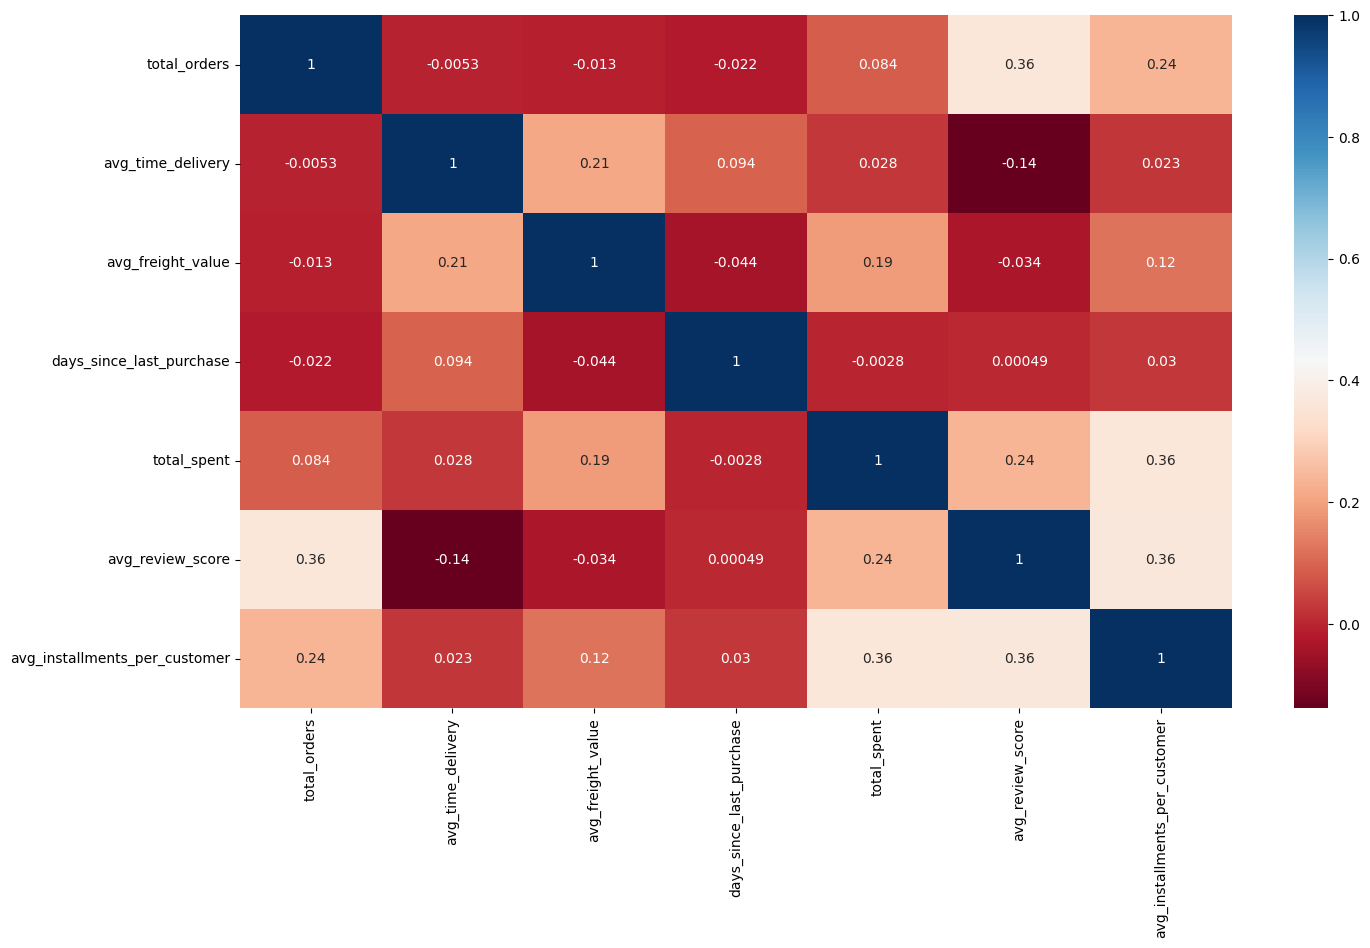

In [206]:
matrix=df.drop(columns=['customer_unique_id'])
plt.figure(figsize=(16,9))
sns.heatmap(matrix.corr(),annot=True,cmap='RdBu')
plt.show()

In [207]:

fig_list = [
    px.scatter(matrix, x='total_orders'),
    px.box(matrix, x='avg_time_delivery'),
    px.box(matrix, x='avg_freight_value'),
    px.box(matrix, x='days_since_last_purchase'),
    px.box(matrix, x='total_spent'),
    px.box(matrix, x='avg_review_score'),
    px.box(matrix, x='avg_installments_per_customer')
]


fig = make_subplots(
    rows=2, cols=4,
    subplot_titles=('Total Orders x Quantity', 'Average time delivery', 'Average freight value',
                    'Days since last purchase', 'Total Spent', 'Average review score',
                    'Average installments per customer')
)


for i, figx in enumerate(fig_list, start=1):
    row = 1 if i <= 4 else 2
    col = i if i <= 4 else i - 4
    for trace in figx.data:
        fig.add_trace(trace, row=row, col=col)

fig.show()


#Data Preprocessing

In this step, we only apply scaling using the Standard Scaler.



In [208]:
scaler=StandardScaler()

scaled_features=scaler.fit_transform(df.iloc[:,1:8])

In [209]:
scaled_features

array([[-1.60271510e-01, -4.28738855e-01,  1.04779508e-01, ...,
        -1.05156985e-01, -2.65671179e-01, -3.38660959e-01],
       [-1.60271510e-01,  4.24838131e-01,  1.66020177e+00, ...,
         1.94161651e-01,  1.67088792e-03,  8.98875103e-01],
       [-1.60271510e-01,  1.49180936e+00, -1.53825251e-01, ...,
        -8.79224781e-02,  1.67088792e-03,  6.92619093e-01],
       ...,
       [-1.60271510e-01,  1.91859786e+00, -7.47895664e-02, ...,
        -2.49301579e-01, -1.06769738e+00,  2.80107072e-01],
       [-1.60271510e-01, -1.95036203e-03,  1.16792932e-01, ...,
         7.90212162e-01,  1.67088792e-03, -3.38660959e-01],
       [-1.60271510e-01, -5.35435979e-01, -7.86743009e-01, ...,
        -3.03687081e-01,  1.67088792e-03, -5.44916969e-01]])

#Clustering with K-Means

We start by training an initial model using K-Means. To determine the optimal number of clusters, we analyze the relationship between the number of clusters and the squared error, as well as the number of clusters and the silhouette score. Based on the elbow method, we choose 4 clusters.

After training the model with 4 clusters, we create several plots to address hypothetical business questions.


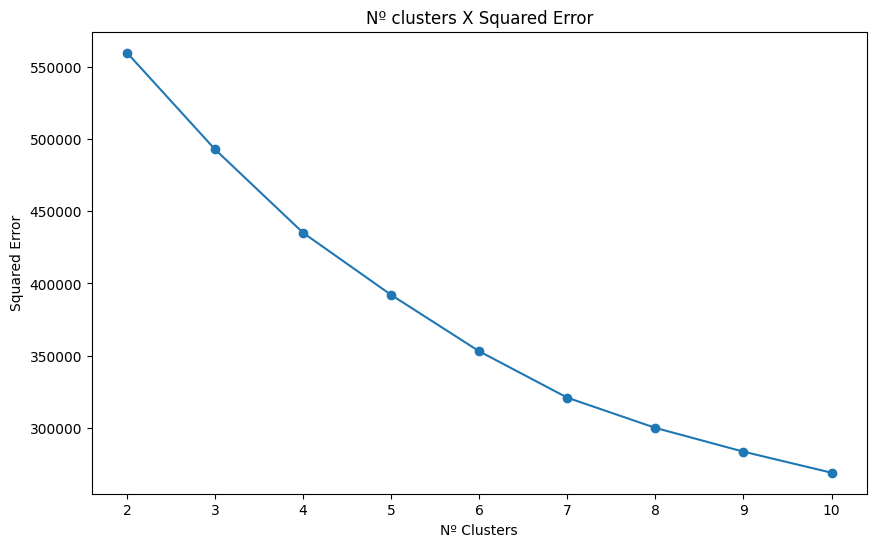

In [28]:
squared_error=[]

for i in range(2,11):
  km=KMeans(n_clusters=i,random_state=0)
  km.fit(scaled_features)
  squared_error.append(km.inertia_)

plt.figure(figsize=(10,6))
plt.plot(range(2,11),squared_error,marker='o')
plt.xlabel('Nº Clusters')
plt.ylabel('Squared Error')
plt.title('Nº clusters X Squared Error')
plt.show()

As we increase the number of clusters, the squared error decreases significantly. Ideally, we would look for a balance, such as 4, 5, or 6 clusters. However, we will use the silhouette metric to make a more informed decision.

Finished clustering for 2 clusters
Finished clustering for 3 clusters
Finished clustering for 4 clusters
Finished clustering for 5 clusters
Finished clustering for 6 clusters
Finished clustering for 7 clusters
Finished clustering for 8 clusters
Finished clustering for 9 clusters
Finished clustering for 10 clusters


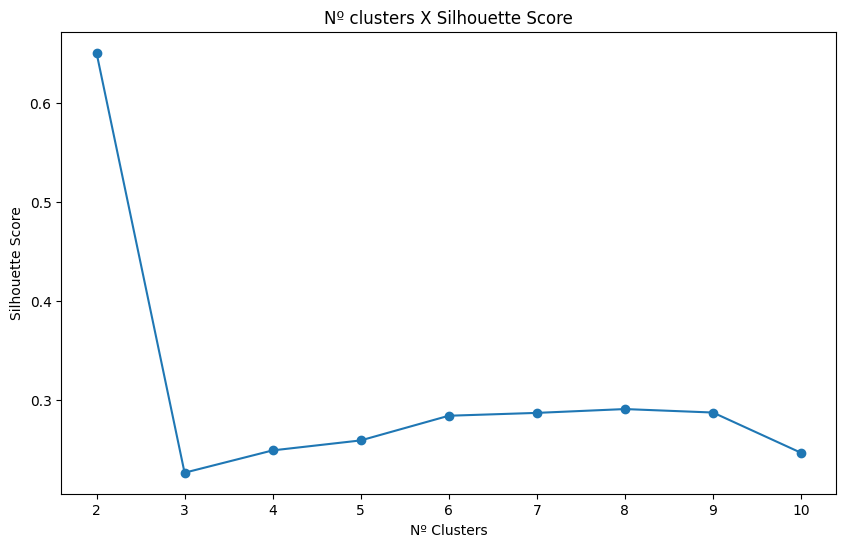

In [30]:
silhouette = []

for i in range(2, 11):
    km = KMeans(n_clusters=i, init='k-means++', n_init=5)
    km.fit(scaled_features)
    silhouettescore = silhouette_score(scaled_features, km.labels_)
    silhouette.append(silhouettescore)
    print(f"Finished clustering for {i} clusters")

plt.figure(figsize=(10, 6))
plt.plot(range(2, 11), silhouette, marker='o')
plt.xlabel('Nº Clusters')
plt.ylabel('Silhouette Score')
plt.title('Nº clusters X Silhouette Score')
plt.show()


We aim for a high silhouette score while maintaining a low average error. In this case, the configuration with 4 clusters best meets these expectations.

In [210]:
kmeans=KMeans(n_clusters=4,n_init=10,init='random',max_iter=300)
kmeans.fit(scaled_features)


KMeans(init='random', n_clusters=4, n_init=10)

In [211]:
df_kmeans=df.copy()
df_kmeans.drop(columns='customer_unique_id',axis=1,inplace=True)
df_kmeans['cluster']=kmeans.labels_

In [212]:
df_kmeans

total_orders  avg_time_delivery  avg_freight_value  \
0                  1                8.0              21.88   
1                  1               16.0              46.48   
2                  1               26.0              17.79   
3                  1               14.0              23.36   
4                  1               11.0              22.25   
...              ...                ...                ...   
117324             1                6.0              13.88   
117325             1                7.0              14.16   
117326             1               30.0              19.04   
117327             1               12.0              22.07   
117328             1                7.0               7.78   

        days_since_last_purchase  total_spent  avg_review_score  \
0                            474       146.87                 4   
1                            233       335.48                 5   
2                            106       157.73                 5   
3                            173       173.30                 5   
4                             35       252.25                 5   
...                          ...          ...               ...   
117324                       148        88.78                 4   
117325                       152       129.06                 5   
117326                       147        56.04                 1   
117327                       303       711.07                 5   
117328                       257        21.77                 5   

        avg_installments_per_customer  cluster  
0                                   2        1  
1                                   8        0  
2                                   7        0  
3                                   1        2  
4                                   8        2  
...                               ...      ...  
117324                              6        2  
117325                              3        2  
117326                              5        0  
117327                              2        1  
117328                              1        2  

[94720 rows x 8 columns]

In [213]:
df_kmeans.groupby('cluster').mean()

total_orders  avg_time_delivery  avg_freight_value  \
cluster                                                       
0            1.000158          26.299424          41.608525   
1            1.000000          10.686884          16.927445   
2            1.000000           8.995083          16.712412   
3            1.887715          11.602954          19.412339   

         days_since_last_purchase  total_spent  avg_review_score  \
cluster                                                            
0                      223.943256   348.287797          3.587010   
1                      398.792771   163.010254          4.810477   
2                      128.324387   154.797962          4.795079   
3                      231.442746   931.234408         14.133685   

         avg_installments_per_customer  
cluster                                 
0                             4.442191  
1                             3.370779  
2                             2.857868  
3                            13.056976

In [214]:
df_kmeans.groupby('cluster').median()

total_orders  avg_time_delivery  avg_freight_value  \
cluster                                                       
0                 1.0               25.0            34.1500   
1                 1.0               10.0            15.6550   
2                 1.0                8.0            15.6100   
3                 2.0               10.0            16.4725   

         days_since_last_purchase  total_spent  avg_review_score  \
cluster                                                            
0                           208.0      186.570               4.0   
1                           388.0      102.030               5.0   
2                           127.0       99.800               5.0   
3                           210.0      323.455              10.0   

         avg_installments_per_customer  
cluster                                 
0                                  3.0  
1                                  2.0  
2                                  2.0  
3                                  7.5

In [215]:
fig_list = [
    px.box(df_kmeans[df_kmeans['cluster'] == 0], x='avg_time_delivery'),
    px.box(df_kmeans[df_kmeans['cluster'] == 1], x='avg_time_delivery'),
    px.box(df_kmeans[df_kmeans['cluster'] == 2], x='avg_time_delivery'),
    px.box(df_kmeans[df_kmeans['cluster'] == 3], x='avg_time_delivery')
]
fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=('Average time delivery - Cluster 0', 'Average time delivery - Cluster 1', 'Average time delivery - Cluster 2',
                    'Average time delivery - Cluster 3')
)


for i, figx in enumerate(fig_list, start=1):
    row = 1 if i <= 2 else 2
    col = i if i <= 2 else i - 2
    for trace in figx.data:
        fig.add_trace(trace, row=row, col=col)

fig.show()


We can observe from the box plots that the clusters are fairly well-segmented, as indicated by the different boxes.

Notably, 3/4 of the deliveries in Cluster 1 take 32 days!

In [216]:
fig_list = [
    px.box(df_kmeans[df_kmeans['cluster'] == 0], x='days_since_last_purchase'),
    px.box(df_kmeans[df_kmeans['cluster'] == 1], x='days_since_last_purchase'),
    px.box(df_kmeans[df_kmeans['cluster'] == 2], x='days_since_last_purchase'),
    px.box(df_kmeans[df_kmeans['cluster'] == 3], x='days_since_last_purchase')
]
fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=('Days since last purchase - Cluster 0', 'Days since last purchase - Cluster 1', 'Days since last purchase - Cluster 2',
                    'Days since last purchase - Cluster 3')
)


for i, figx in enumerate(fig_list, start=1):
    row = 1 if i <= 2 else 2
    col = i if i <= 2 else i - 2
    for trace in figx.data:
        fig.add_trace(trace, row=row, col=col)

fig.show()


In [217]:
fig_list = [
    px.box(df_kmeans[df_kmeans['cluster'] == 0], x='total_spent'),
    px.box(df_kmeans[df_kmeans['cluster'] == 1], x='total_spent'),
    px.box(df_kmeans[df_kmeans['cluster'] == 2], x='total_spent'),
    px.box(df_kmeans[df_kmeans['cluster'] == 3], x='total_spent')
]
fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=('Total Spent - Cluster 0', 'Total Spent - Cluster 1', 'Total Spent - Cluster 2',
                    'Total Spent - Cluster 3')
)


for i, figx in enumerate(fig_list, start=1):
    row = 1 if i <= 2 else 2
    col = i if i <= 2 else i - 2
    for trace in figx.data:
        fig.add_trace(trace, row=row, col=col)

fig.show()



Clusters 1 and 2 spend significantly more than Clusters 0 and 3.



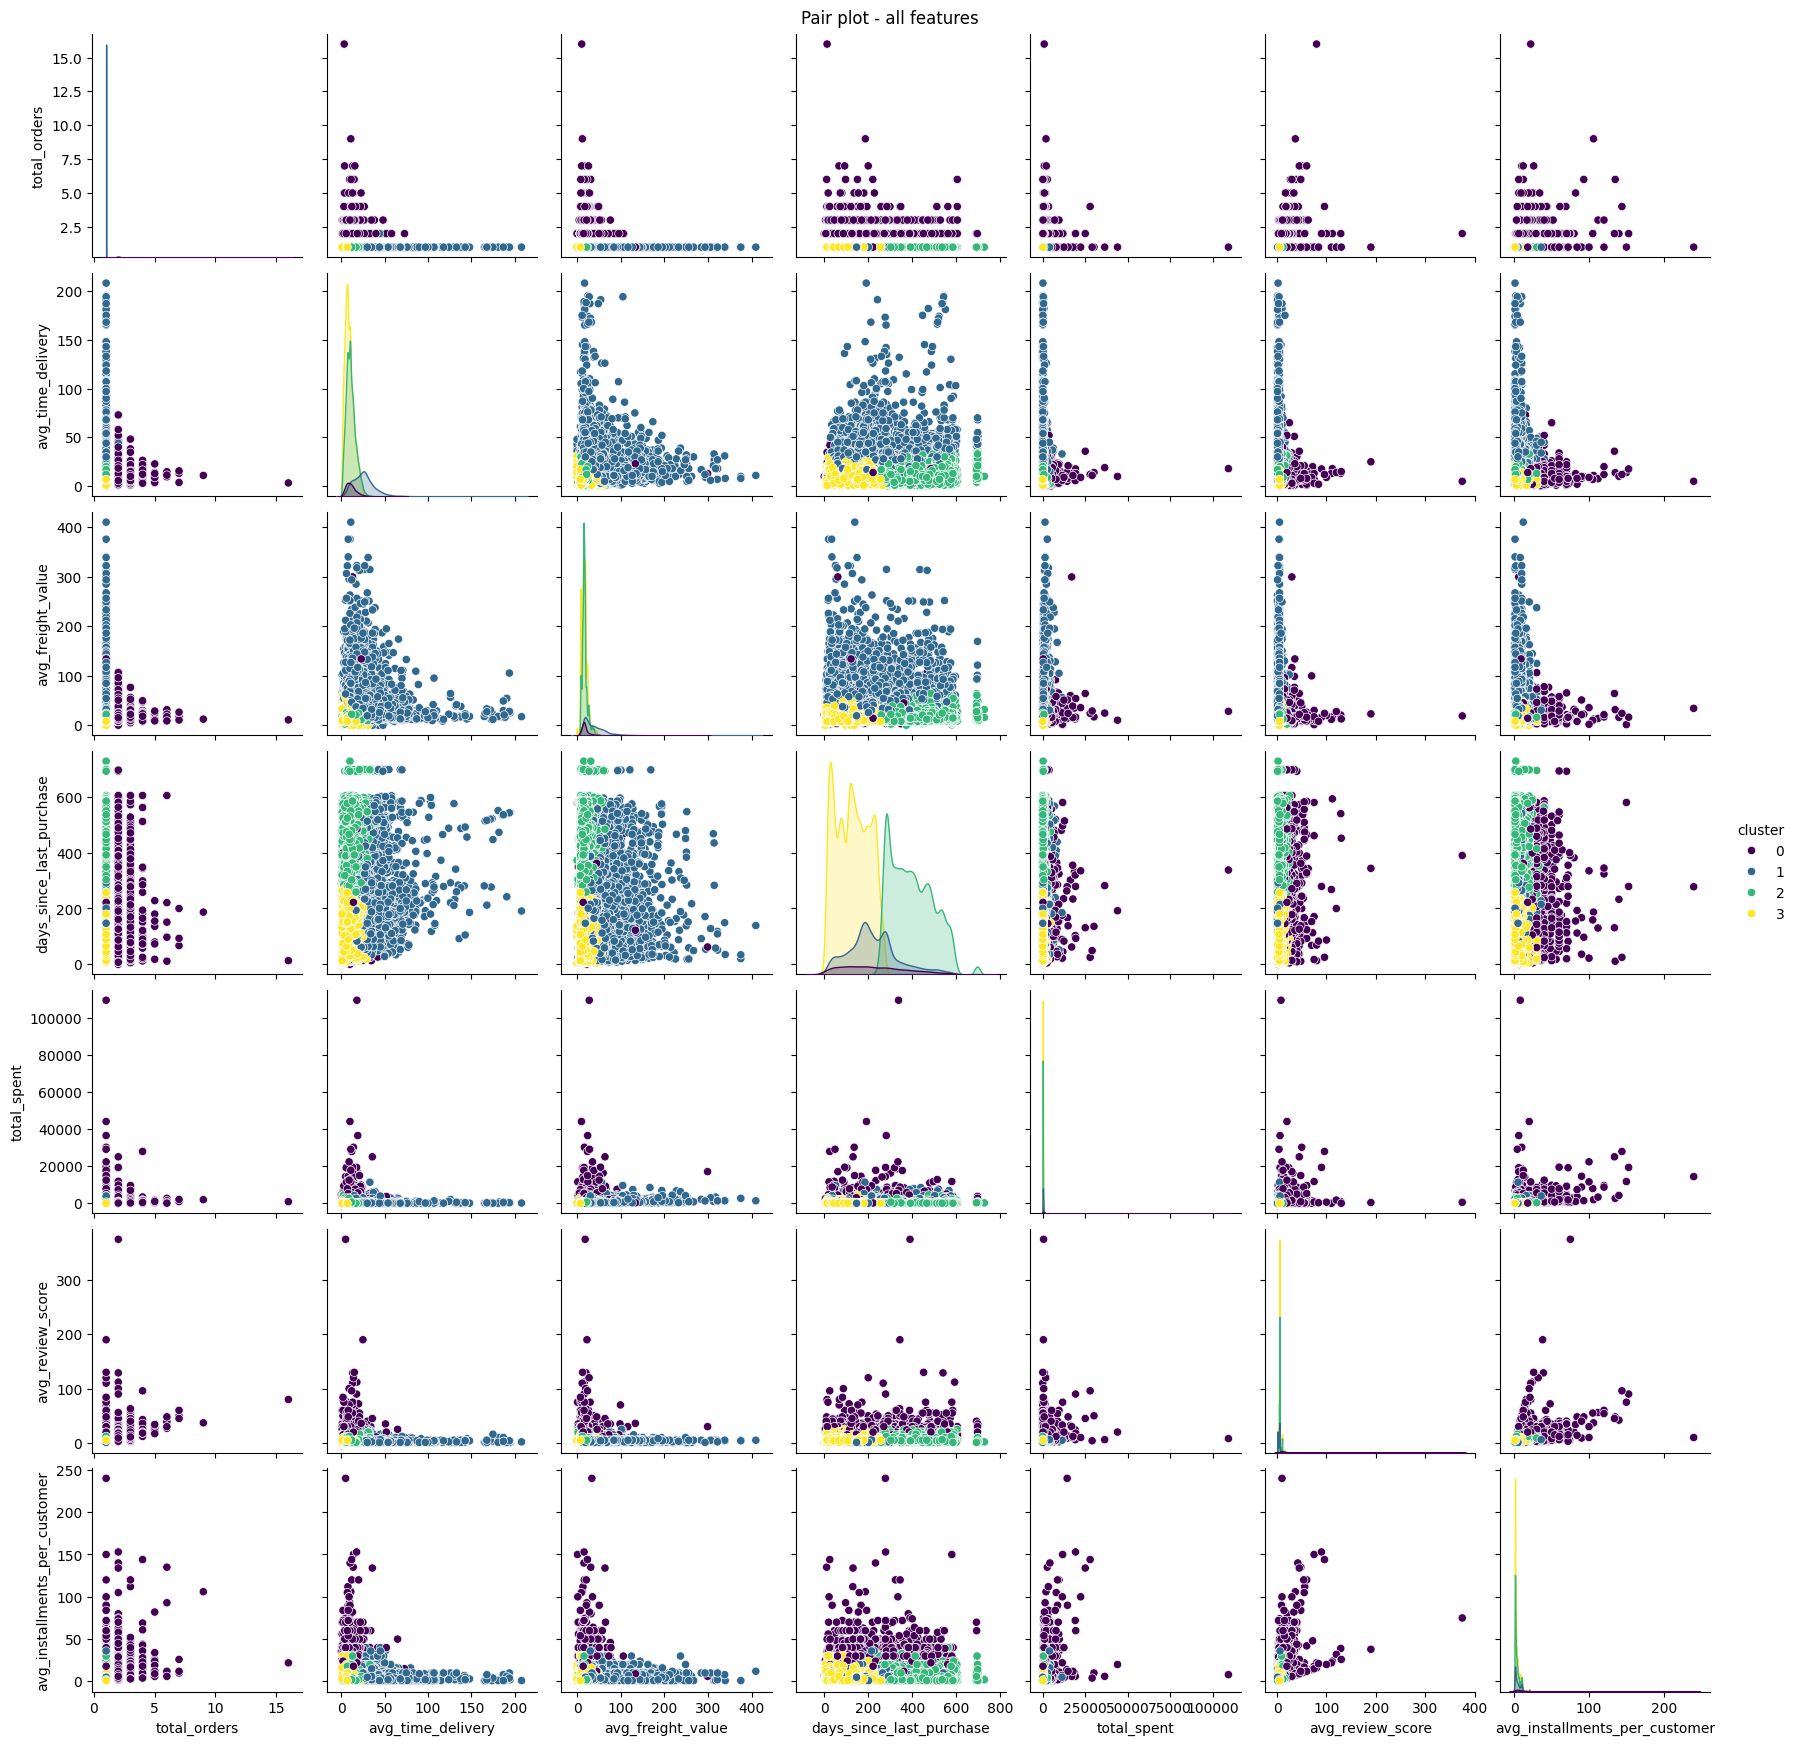

In [63]:
sns.pairplot(df_kmeans,hue='cluster',palette='viridis')
plt.suptitle('Pair plot - all features',y=1.03)
plt.show()

#K-Means with PCA

I wasn't entirely satisfied with the previous results, so I will perform Principal Component Analysis (PCA), which is a technique used to reduce the dimensionality of the data while preserving as much variance as possible. I will choose 5 principal components for this analysis.

After applying PCA, I will follow the same process of analyzing the number of clusters and have selected 6 clusters this time.

In [218]:
pca=PCA()
pca.fit(scaled_features)

PCA()

In [219]:
var=pca.explained_variance_ratio_
df_var=pd.DataFrame(var,index=[f'PC{i+1}' for i in range(len(var))],columns= ['Explained Variance'])

var_acc=pca.explained_variance_ratio_.cumsum()

df_var['Cumulative Variance']=var_acc

df_var

Explained Variance  Cumulative Variance
PC1            0.265730             0.265730
PC2            0.188204             0.453933
PC3            0.148568             0.602501
PC4            0.131038             0.733539
PC5            0.101176             0.834715
PC6            0.085508             0.920223
PC7            0.079777             1.000000

I will retain 80% of the features, so I will keep up to Principal Component 5.

In [220]:
pca=PCA(n_components=5)
pca.fit(scaled_features)

PCA(n_components=5)

In [221]:
df_pca=pca.transform(scaled_features)
df_pca=pd.DataFrame(df_pca)
df_pca.columns=['C1', 'C2', 'C3', 'C4', 'C5']

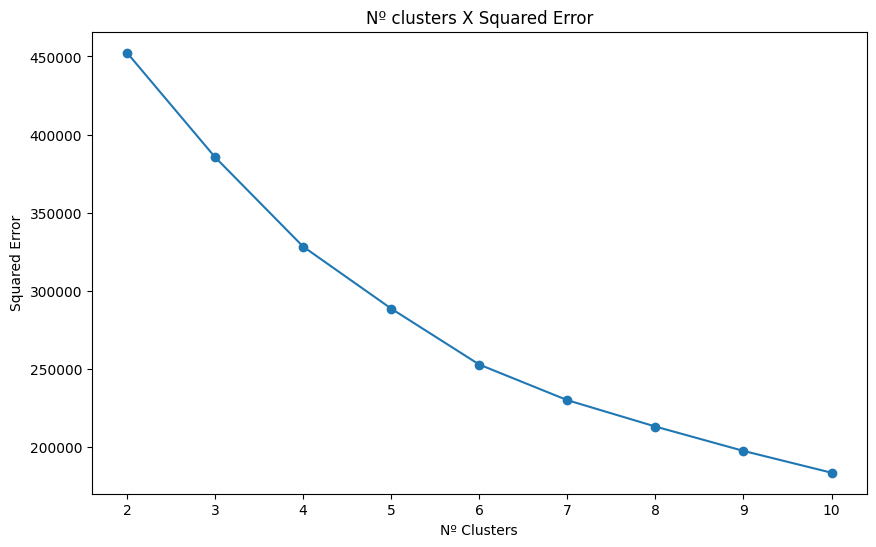

In [95]:
squared_error=[]

for i in range(2,11):
  km=KMeans(n_clusters=i,random_state=0)
  km.fit(df_pca)
  squared_error.append(km.inertia_)

plt.figure(figsize=(10,6))
plt.plot(range(2,11),squared_error,marker='o')
plt.xlabel('Nº Clusters')
plt.ylabel('Squared Error')
plt.title('Nº clusters X Squared Error')
plt.show()

Finished clustering for 2 clusters
Finished clustering for 3 clusters
Finished clustering for 4 clusters
Finished clustering for 5 clusters
Finished clustering for 6 clusters
Finished clustering for 7 clusters
Finished clustering for 8 clusters
Finished clustering for 9 clusters
Finished clustering for 10 clusters


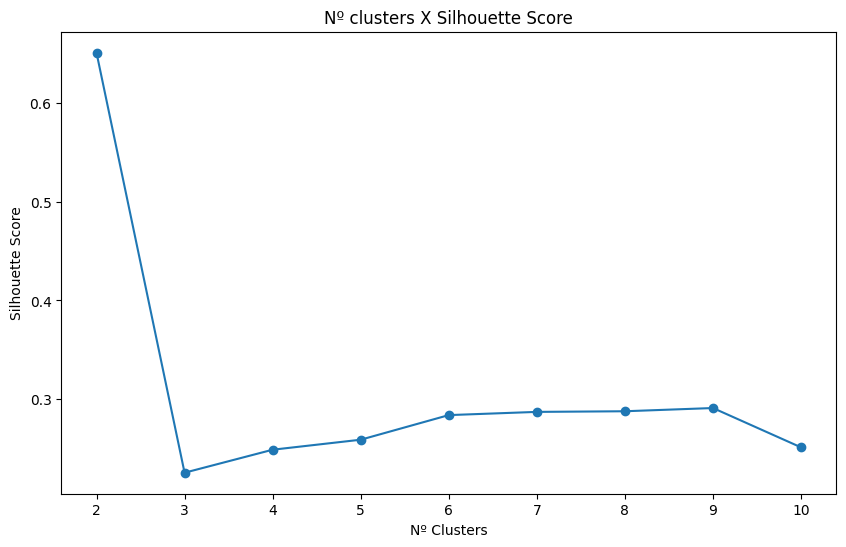

In [96]:
silhouette = []

for i in range(2, 11):
    km = KMeans(n_clusters=i, init='k-means++', n_init=5)
    km.fit(scaled_features)
    silhouettescore = silhouette_score(scaled_features, km.labels_)
    silhouette.append(silhouettescore)
    print(f"Finished clustering for {i} clusters")

plt.figure(figsize=(10, 6))
plt.plot(range(2, 11), silhouette, marker='o')
plt.xlabel('Nº Clusters')
plt.ylabel('Silhouette Score')
plt.title('Nº clusters X Silhouette Score')
plt.show()


In [222]:
kmeans_pca=KMeans(n_clusters=6,n_init=10,init='random',max_iter=300)
kmeans_pca.fit(df_pca)

KMeans(init='random', n_clusters=6, n_init=10)

In [223]:
df_pca['cluster']=kmeans_pca.labels_
df_pca



C1        C2        C3        C4        C5  cluster
0     -0.423626  0.030821 -1.175442  0.650872 -0.798478        1
1      0.750112  1.472658  0.428277 -0.009592 -0.653283        5
2      0.222167  0.795559  0.344040 -0.790409  1.296020        0
3     -0.373234  0.167987  0.442924 -0.260476  0.004164        4
4      0.484449 -0.003485  1.271416 -0.074381  0.499404        4
...         ...       ...       ...       ...       ...      ...
94715 -0.070730 -0.609973  0.595917  0.261436  0.240173        4
94716 -0.242087 -0.650454  0.567326  0.133632  0.135938        4
94717 -0.651914  1.362280  0.082176 -1.002172  1.351350        0
94718  0.119545  0.330893 -0.166706  0.537543 -0.035624        1
94719 -0.608064 -0.909608 -0.169924  0.215914  0.077460        4

[94720 rows x 6 columns]

In [224]:
df_result=pd.concat([df.drop(columns='customer_unique_id',axis=1),df_pca],axis=1)
df_result.head()

total_orders  avg_time_delivery  avg_freight_value  \
0           1.0                8.0              21.88   
1           1.0               16.0              46.48   
2           1.0               26.0              17.79   
3           1.0               14.0              23.36   
4           1.0               11.0              22.25   

   days_since_last_purchase  total_spent  avg_review_score  \
0                     474.0       146.87               4.0   
1                     233.0       335.48               5.0   
2                     106.0       157.73               5.0   
3                     173.0       173.30               5.0   
4                      35.0       252.25               5.0   

   avg_installments_per_customer        C1        C2        C3        C4  \
0                            2.0 -0.423626  0.030821 -1.175442  0.650872   
1                            8.0  0.750112  1.472658  0.428277 -0.009592   
2                            7.0  0.222167  0.795559  0.344040 -0.790409   
3                            1.0 -0.373234  0.167987  0.442924 -0.260476   
4                            8.0  0.484449 -0.003485  1.271416 -0.074381   

         C5  cluster  
0 -0.798478      1.0  
1 -0.653283      5.0  
2  1.296020      0.0  
3  0.004164      4.0  
4  0.499404      4.0

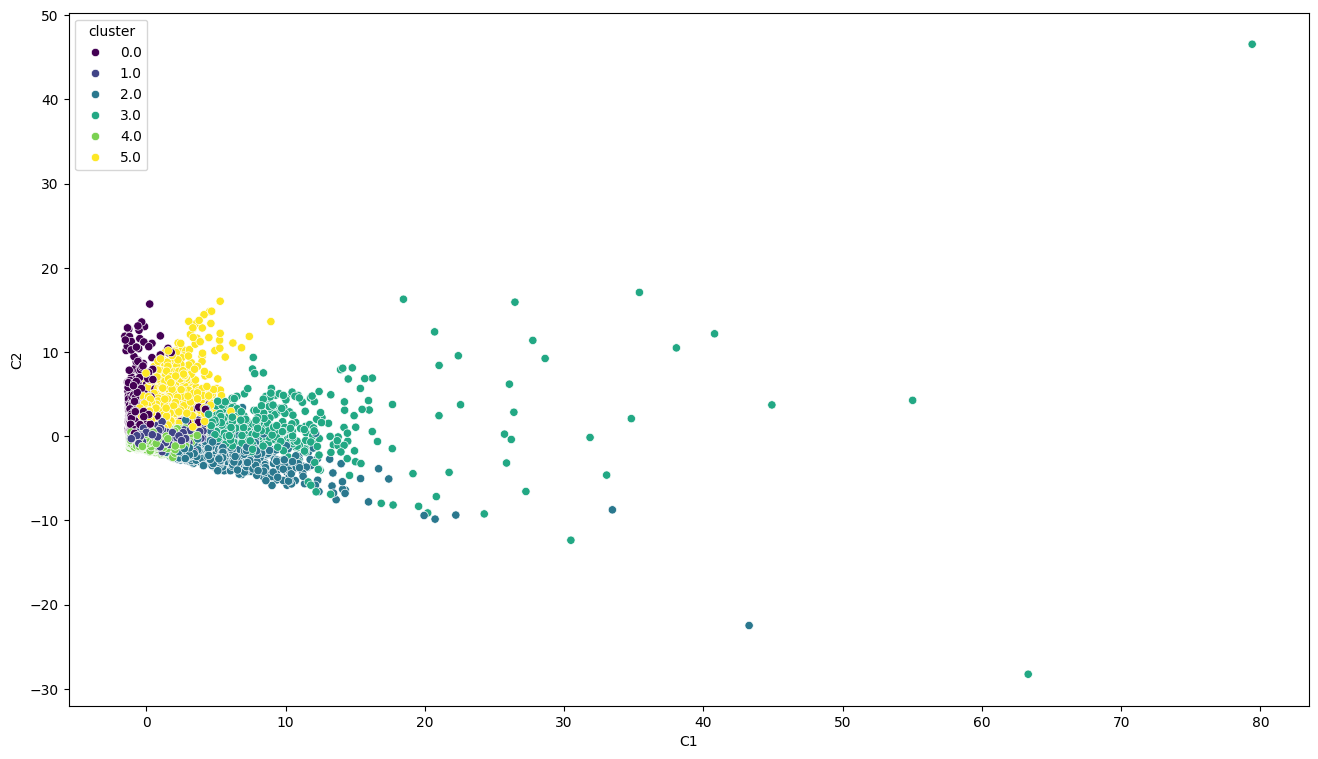

In [225]:
plt.figure(figsize=(16,9))
sns.scatterplot(data=df_result,x='C1',y='C2',hue='cluster',palette='viridis')
plt.xlabel=('c1')
plt.ylabel=('c2')
plt.show()

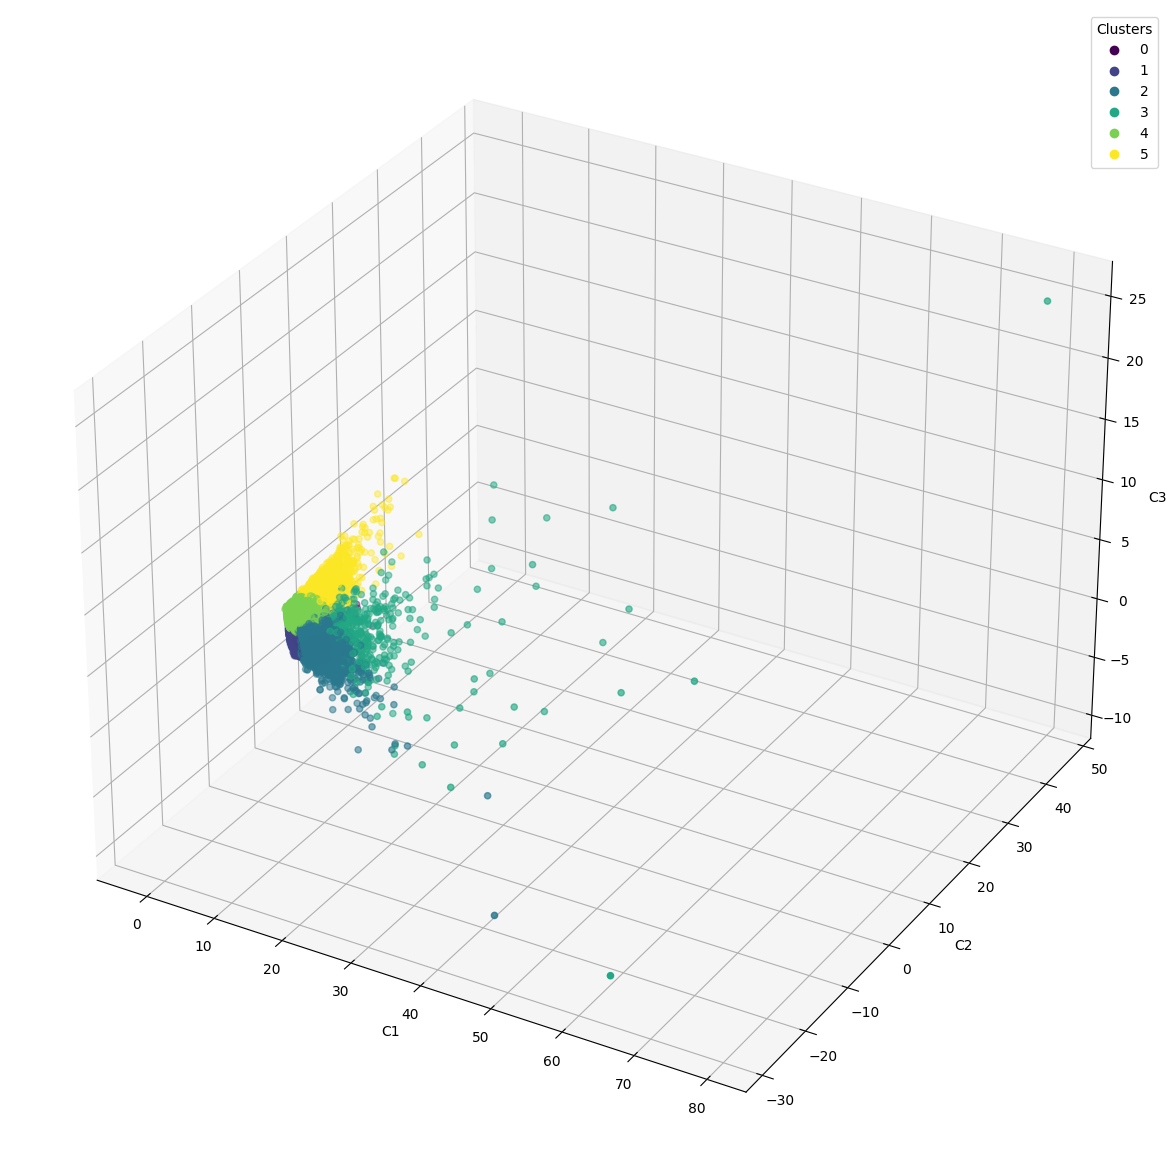

In [228]:
fig = plt.figure(figsize=(16, 15))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(df_result['C1'], df_result['C2'], df_result['C3'], c=df_result['cluster'])
ax.set_xlabel('C1')
ax.set_ylabel('C2')
ax.set_zlabel('C3')

plt.legend(*scatter.legend_elements(), title="Clusters")

plt.show()


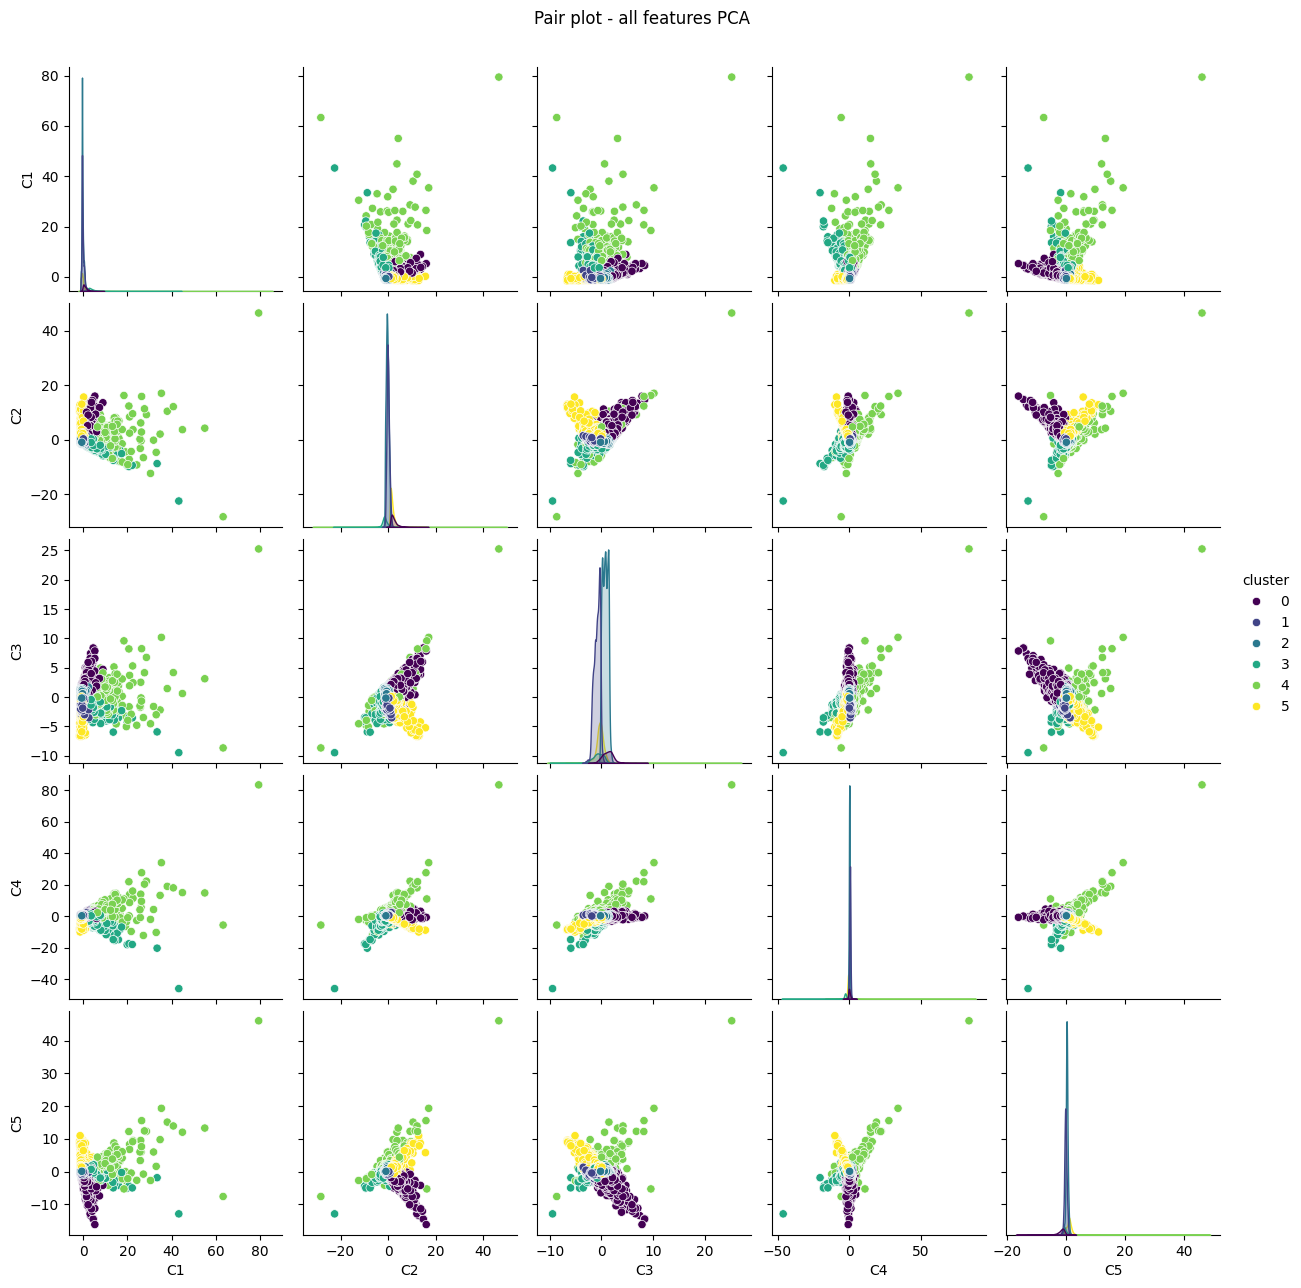

In [158]:
sns.pairplot(df_pca,hue='cluster',palette='viridis')
plt.suptitle('Pair plot - all features PCA ',y=1.03)
plt.show()

In [159]:
df_pca.groupby('cluster').mean().reset_index()


cluster        C1        C2        C3        C4        C5
0        0  0.840726  2.566130  1.215760 -0.015956 -1.839814
1        1 -0.181646 -0.071374 -0.919132  0.443047 -0.250302
2        2 -0.264200 -0.408593  0.701560 -0.009991  0.188610
3        3  3.815418 -1.490925 -0.648021 -2.504230 -0.516585
4        4  9.740499  1.104421  0.312433  3.534967  2.422024
5        5 -0.331029  1.710381 -0.382227 -0.927135  0.970531

In [160]:
df_pca.groupby('cluster').median().reset_index()

cluster        C1        C2        C3        C4        C5
0        0  0.593812  2.062388  1.218957 -0.111595 -1.487893
1        1 -0.383730 -0.118226 -0.840458  0.449194 -0.259844
2        2 -0.435013 -0.436979  0.699979 -0.008464  0.183354
3        3  3.293021 -1.516909 -0.608870 -2.777546 -0.586311
4        4  7.779002  0.828819  0.157420  2.725318  1.990905
5        5 -0.460775  1.442600 -0.304003 -0.828204  0.937821

##Based on the principal component values for Cluster 4, it appears to have quite distinct characteristics, especially with high values in C1, C4, and C5. This suggests that Cluster 4 might represent a group of customers with patterns significantly different from the other clusters, indicating that it could be an "atypical" or "extreme" cluster in terms of the analyzed features.

In [167]:
df_pca_outlier=df_pca[df_pca['cluster']==4]
df_pca_clean=df_pca[df_pca['cluster']!=4]


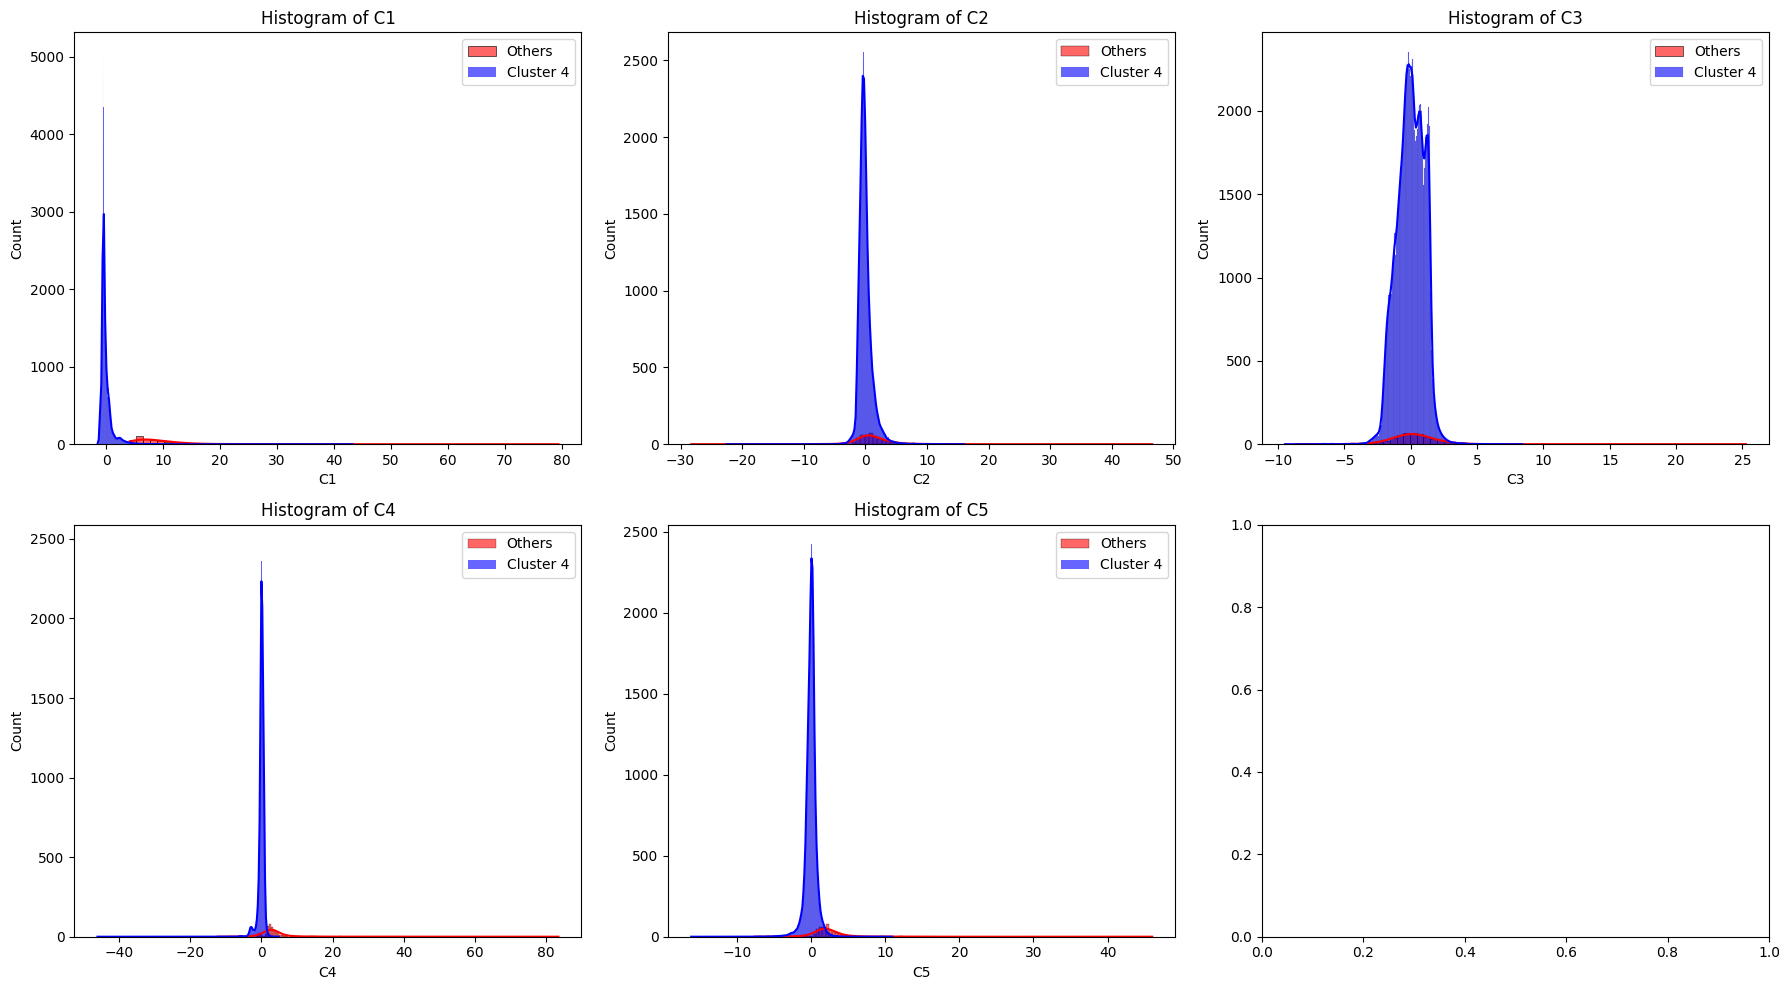

In [168]:
fig, axs = plt.subplots(2, 3, figsize=(18, 10))

components = ['C1', 'C2', 'C3', 'C4', 'C5']
colors = ['red', 'blue']
labels = ['Others', 'Cluster 4']

for i, component in enumerate(components):
    ax = axs[i // 3, i % 3]
    sns.histplot(data=df_pca_outlier, x=component, color=colors[0], label=labels[0], kde=True, alpha=0.6, ax=ax)
    sns.histplot(data=df_pca_clean, x=component, color=colors[1], label=labels[1], kde=True, alpha=0.6, ax=ax)
    ax.set_title(f'Histogram of {component}')
    ax.legend()

plt.tight_layout()
plt.show()


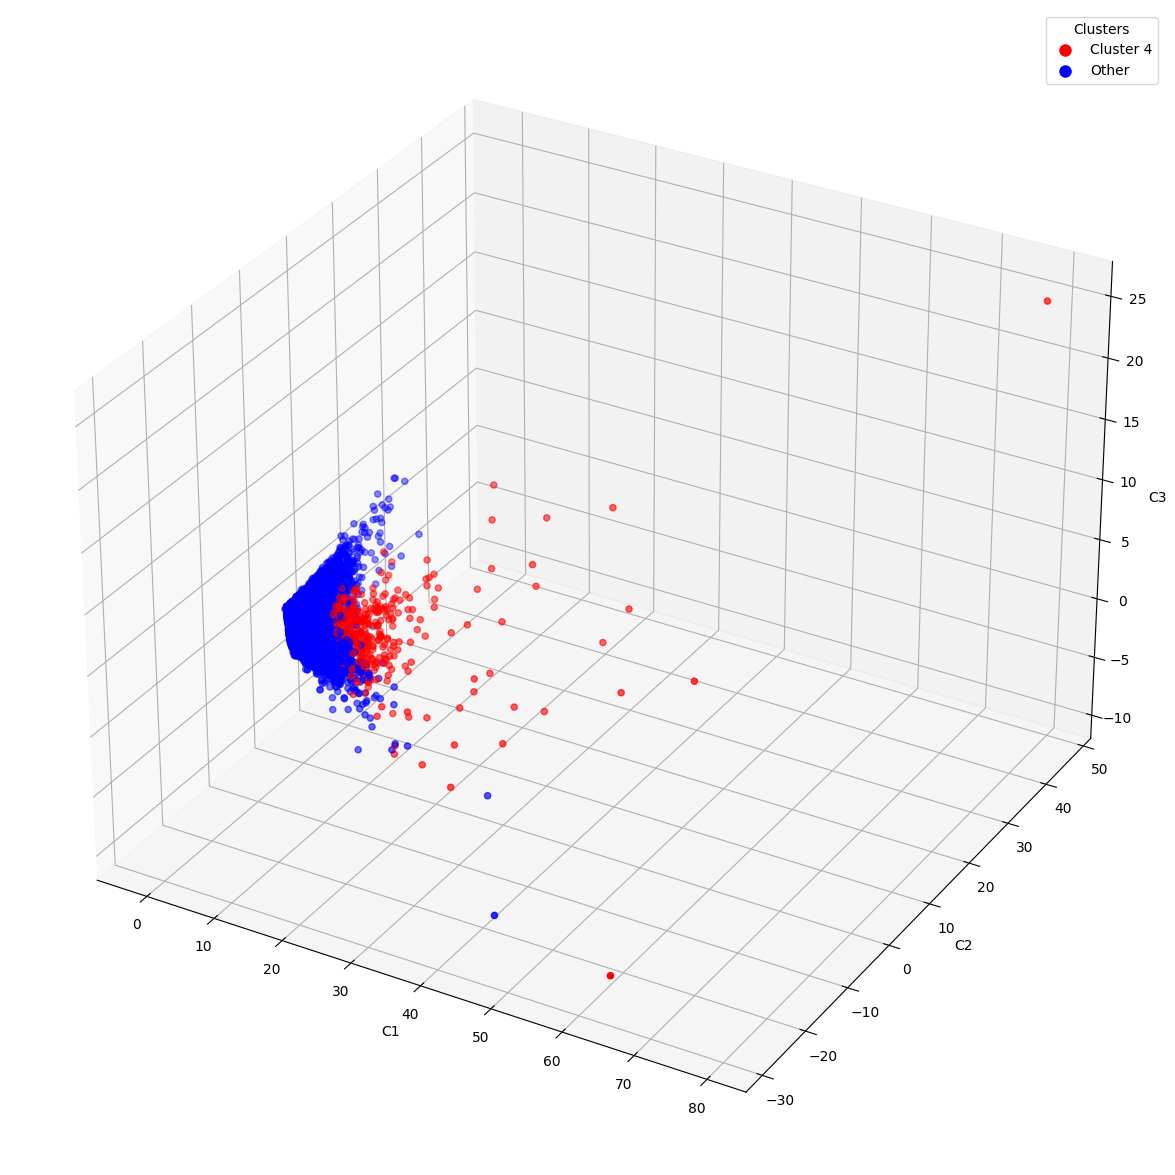

In [174]:


fig = plt.figure(figsize=(16, 15))
ax = fig.add_subplot(111, projection='3d')

colors = {'Cluster 4': 'r', 'Other': 'b'}
df_result['color'] = df_result['cluster'].map(colors)

scatter = ax.scatter(df_result['C1'], df_result['C2'], df_result['C3'], c=df_result['color'])
ax.set_xlabel('C1')
ax.set_ylabel('C2')
ax.set_zlabel('C3')


handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='r', markersize=10, label='Cluster 4'),
           plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='b', markersize=10, label='Other')]
ax.legend(handles=handles, title="Clusters")

plt.show()


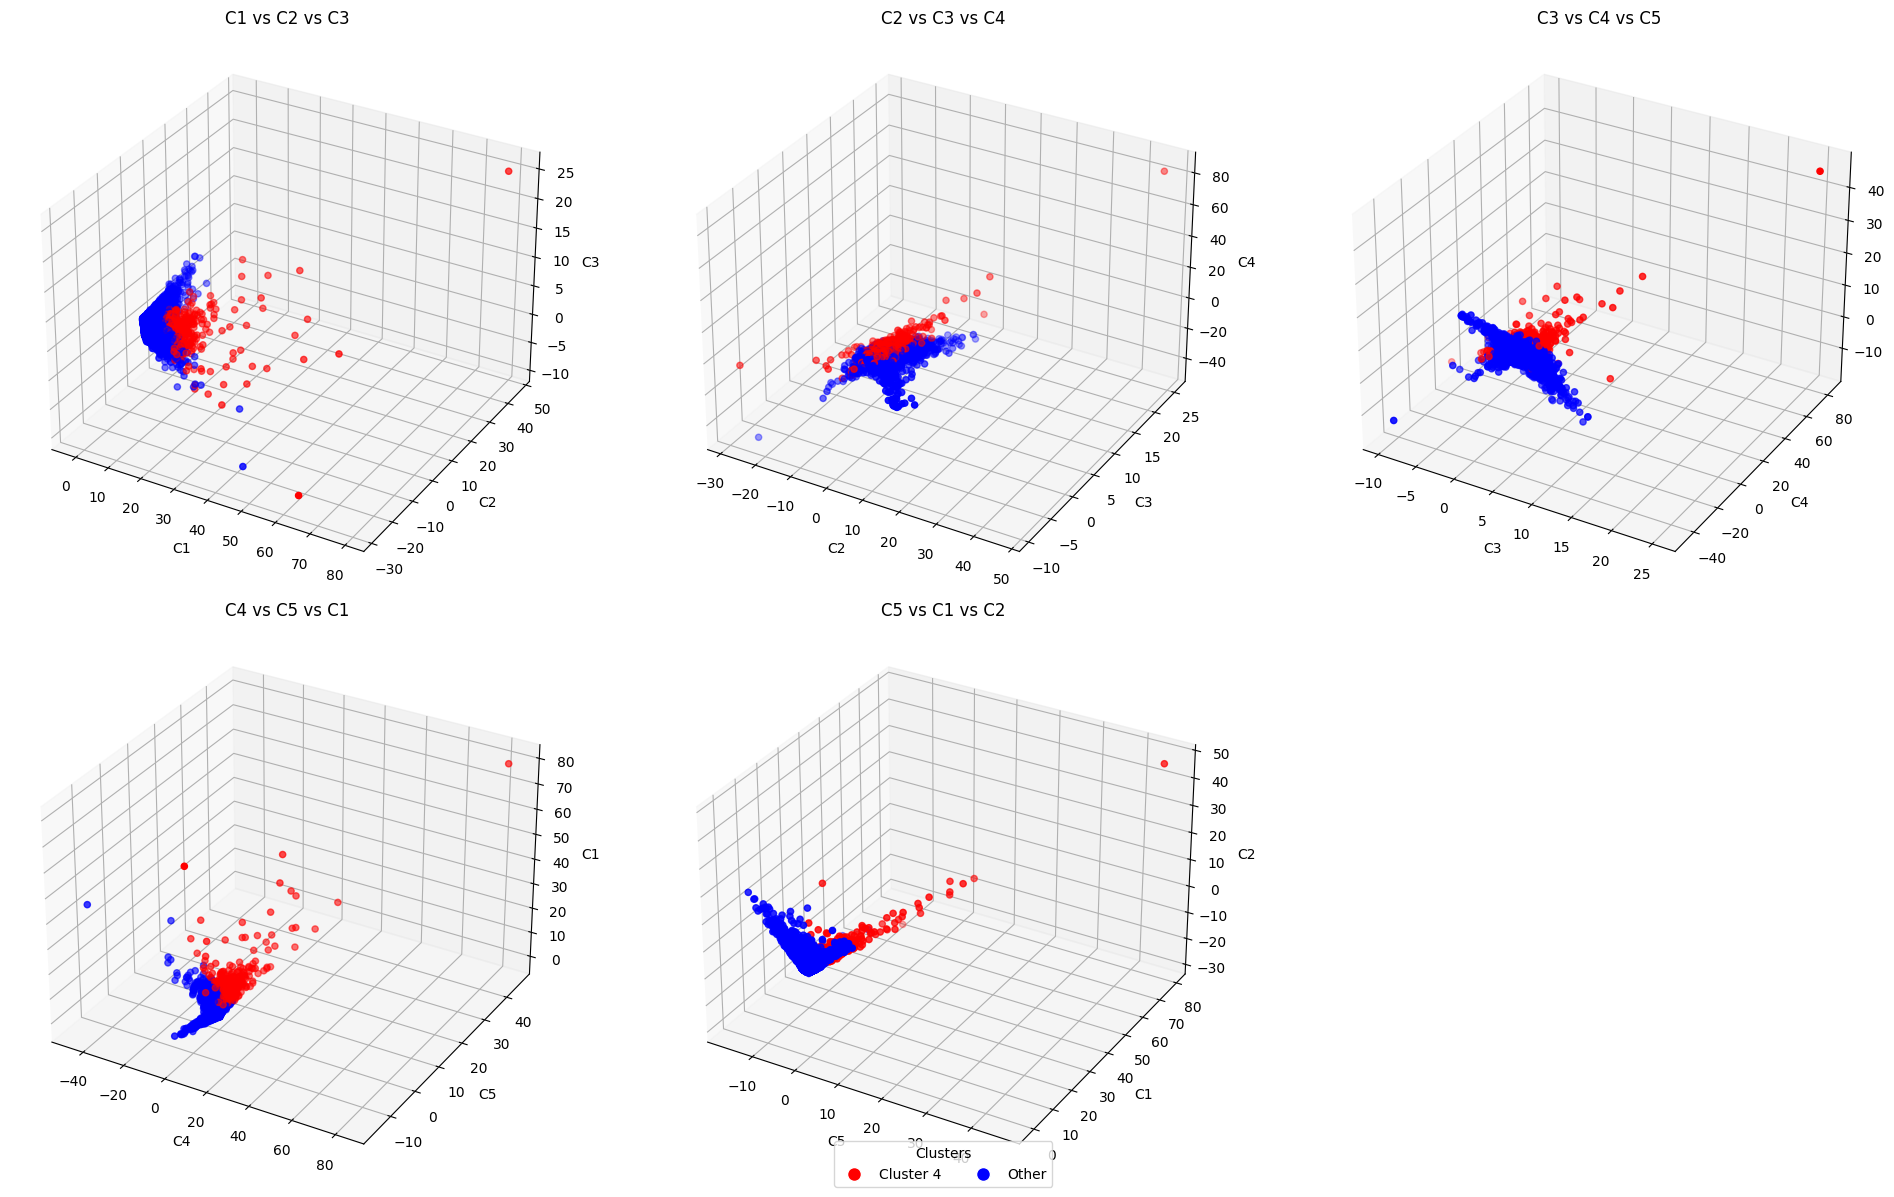

In [175]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(20, 12))

# Combinations of features for the 6 subplots
combinations = [
    ('C1', 'C2', 'C3'),
    ('C2', 'C3', 'C4'),
    ('C3', 'C4', 'C5'),
    ('C4', 'C5', 'C1'),
    ('C5', 'C1', 'C2')
]

# Colors mapping
colors = {'Cluster 4': 'r', 'Other': 'b'}
df_result['color'] = df_result['cluster'].map(colors)

for i, (x, y, z) in enumerate(combinations):
    ax = fig.add_subplot(2, 3, i+1, projection='3d')
    scatter = ax.scatter(df_result[x], df_result[y], df_result[z], c=df_result['color'])
    ax.set_xlabel(x)
    ax.set_ylabel(y)
    ax.set_zlabel(z)
    ax.set_title(f'{x} vs {y} vs {z}')

# Add a legend to the figure (only once)
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='r', markersize=10, label='Cluster 4'),
           plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='b', markersize=10, label='Other')]
fig.legend(handles=handles, title="Clusters", loc='upper center', bbox_to_anchor=(0.5, 0.05), ncol=2)

plt.tight_layout()
plt.show()
